In [1]:
! pip install opendatasets --upgrade --quiet
! pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import pandas as pd
import os
import opendatasets as od

In [3]:
from PIL import Image
import numpy as np
import tqdm
import cv2
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet

target_shape = (200, 200)

In [5]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/c/11-785-fall-20-homework-2-part-2'
# Using opendatasets let's download the data sets
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: satoutakara
Your Kaggle Key: ··········


100%|██████████| 1.35G/1.35G [01:02<00:00, 23.1MB/s]



Extracting archive ./11-785-fall-20-homework-2-part-2/11-785-fall-20-homework-2-part-2.zip to ./11-785-fall-20-homework-2-part-2


In [6]:
max_folders = 4000
max_images_per_folder = 14

In [7]:
import os
import cv2
import numpy as np

def load_data(data_path):
    # Loads data and preprocesses it, returns train and test data along with labels
    images = []
    labels = []

    print('Loading Data from File ', end='')
    folder_count = 0
    for folder in os.listdir(data_path):
        path = os.path.join(data_path, folder)
        # print(folder, end='|')
        image_count = 1
        for image in os.listdir(path):
            images.append(os.path.join(path, image))
            labels.append(folder_count)
            image_count += 1

        folder_count += 1

    return images, labels

In [8]:
base_path = '/content/11-785-fall-20-homework-2-part-2/classification_data/'
train_path = os.path.join(base_path, 'train_data')
val_path = os.path.join(base_path, 'val_data')
test_path = os.path.join(base_path, 'test_data')
base_path_ver = '/content/11-785-fall-20-homework-2-part-2/'
ver_file_path = os.path.join('/content/11-785-fall-20-homework-2-part-2/verification_pairs_val.txt')

In [9]:
# Extract train images and labels
train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)
test_images, test_labels = load_data(test_path)

Loading Data from File Loading Data from File Loading Data from File 

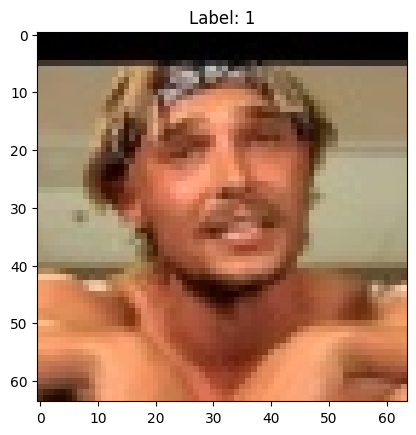

In [10]:
import matplotlib.pyplot as plt
import os

# Find the index of the first image with label 1
index = train_labels.index(1)

# Get the path of the image with label 1
image_path = train_images[index]

# Load and plot the image
image = plt.imread(image_path)
plt.imshow(image)
plt.title("Label: 1")
plt.show()

In [11]:
num_classes = train_labels[-1] + 1
num_classes

4000

In [12]:
# Function to preprocess the images
def preprocess_image(filename, label):
    """
    Load the specified file as a JPEG image, preprocess it, resize it to the target shape,
    and normalize it.
    """
    # Load the image
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)

    # Convert image to float32 and resize
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)

    return image, label

In [13]:
len(train_labels)

380638

In [14]:
# Create a TensorFlow dataset
train_images_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)

train_dataset = tf.data.Dataset.zip((train_images_dataset, train_labels_dataset))

# Shuffle the dataset (optional but recommended for training)
train_dataset = train_dataset.shuffle(buffer_size=len(train_images))

# Prefetch to improve performance (optional but recommended)
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Batch the dataset (e.g., batch size of 32)
batch_size = 256
train_dataset = train_dataset.batch(batch_size, drop_remainder=False)

In [15]:
# Create a TensorFlow dataset
val_images_dataset = tf.data.Dataset.from_tensor_slices(val_images)
val_labels_dataset = tf.data.Dataset.from_tensor_slices(val_labels)

val_dataset = tf.data.Dataset.zip((val_images_dataset, val_labels_dataset))

# Prefetch to improve performance (optional but recommended)
val_dataset = val_dataset.map(preprocess_image)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Batch the dataset (e.g., batch size of 32)
batch_size = 256
val_dataset = val_dataset.batch(batch_size, drop_remainder=False)

In [16]:
# Create a TensorFlow dataset
test_images_dataset = tf.data.Dataset.from_tensor_slices(test_images)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_images_dataset, test_labels_dataset))

# Prefetch to improve performance (optional but recommended)
test_dataset = test_dataset.map(preprocess_image)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

# Batch the dataset (e.g., batch size of 32)
batch_size = 256
test_dataset = test_dataset.batch(batch_size, drop_remainder=False)

In [17]:
import os
import tensorflow as tf

def preprocess_ver_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it, resize it to the target shape,
    and normalize it.
    """

    # Load the image
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)

    # Convert image to float32 and resize
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)

    return image

def preprocess_image_pair_label(pair, label):
    return (
        preprocess_ver_image(pair[0]),
        preprocess_ver_image(pair[1]),
        label,
    )

def load_val_verification_data(file_path, image_dir, batch_size):
    pairs = []
    labels = []

    with open(file_path, 'r') as f:
        for line in f:
            pair = line.strip().split()
            pairs.append((os.path.join(image_dir, pair[0]), os.path.join(image_dir, pair[1])))  # Convert list to tuple
            labels.append(float(pair[2]))

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((pairs, labels))
    dataset = dataset.map(preprocess_image_pair_label)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [18]:
ver_dataset = load_val_verification_data(ver_file_path, base_path_ver, 256)

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output_dense = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output_dense, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
from tensorflow.keras.applications import resnet
from tensorflow.keras import layers, models

# Define the input layer for classification model
input_image = layers.Input(shape=target_shape + (3,), name="input_image")

# Preprocess input image using resnet.preprocess_input
preprocessed_input = layers.Lambda(resnet.preprocess_input)(input_image)

# Pass preprocessed input through the embedding model
output_embedding = embedding(preprocessed_input)

# Output layer for classification
output = layers.Dense(num_classes, activation='softmax')(output_embedding)

# Create the complete classification model
classification_model = models.Model(inputs=input_image, outputs=output, name="ClassificationModel")

In [ ]:
classification_model.summary()

Model: "ClassificationModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Embedding (Functional)               │ (None, 256)                 │      75,168,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4000)                │       1,028,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,196,640 (290.67 MB)

 Trainable params: 61,538,720 (234.75 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

In [ ]:
# Compile the model with an initial learning rate and metrics
initial_learning_rate = 0.001
classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    # loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define a learning rate scheduler callback with a minimum learning rate
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.1,              # Factor by which the learning rate will be reduced
    patience=1,              # Number of epochs with no improvement after which learning rate will be reduced
    mode='min',              # Mode for determining the improvement
    min_delta=0.0001,        # Threshold for measuring the new optimum
    cooldown=0,              # Number of epochs to wait after the learning rate is changed
    min_lr=0.00001,          # Minimum learning rate
    verbose=1                # Print message when the learning rate is reduced
)

# Example training code
history = classification_model.fit(
    train_dataset,           # Your training dataset
    epochs=10,               # Number of epochs
    validation_data=val_dataset,  # Your validation dataset
    callbacks=[lr_scheduler]  # Add the learning rate scheduler callback
)

Epoch 1/10
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 200s 116ms/step - accuracy: 0.0133 - loss: 7.3780 - val_accuracy: 2.5000e-04 - val_loss: 55.8091 - learning_rate: 0.0010
Epoch 2/10
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0849 - loss: 5.7547
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 151s 101ms/step - accuracy: 0.0849 - loss: 5.7547 - val_accuracy: 2.5000e-04 - val_loss: 76.3062 - learning_rate: 0.0010
Epoch 3/10
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 151s 101ms/step - accuracy: 0.1789 - loss: 4.8379 - val_accuracy: 0.0322 - val_loss: 7.9681 - learning_rate: 1.0000e-04
Epoch 4/10
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 151s 101ms/step - accuracy: 0.2102 - loss: 4.5812 - val_accuracy: 0.0320 - val_loss: 7.7470 - learning_rate: 1.0000e-04
Epoch 5/10
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2243 - loss: 4.4598
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1487/1487 ━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [24]:
# Evaluate the model on the test dataset (if you have one)
test_loss, test_accuracy = classification_model.evaluate(test_dataset)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 496ms/step - accuracy: 9.9394e-05 - loss: 8.4756
Test loss: 8.463351249694824
Test accuracy: 0.0001250000059371814


In [19]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

drive_path = '/content/drive/My Drive/Applied ML/project/embedding_classification.h5'  # or 'siamese_model.h5'

embedding = load_model(drive_path)

embedding.summary()

Mounted at /content/drive


Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 206, 206, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 100, 100, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 100, 100, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 100, 100, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 102, 102, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 50, 50, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 50, 50, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 50, 50, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 50, 50, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 50, 50, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 75,168,640 (286.75 MB)

 Trainable params: 60,510,720 (230.83 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

In [ ]:
# Define the PairDistanceLayer and create the pair_model
class PairDistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, image1, image2):
        distance = 1 - ops.sum(tf.square(image1 - image2), -1)
        # Normalize the distance to range from 0 to 1
        return distance

In [ ]:
# Define the input layers
image1_input = layers.Input(name="image1", shape=target_shape + (3,))
image2_input = layers.Input(name="image2", shape=target_shape + (3,))

# Assuming 'embedding' and 'resnet' are defined elsewhere
embedding1 = embedding(resnet.preprocess_input(image1_input))
embedding2 = embedding(resnet.preprocess_input(image2_input))

# Apply the PairDistanceLayer
similarity_scores = PairDistanceLayer()(
    image1=embedding1,
    image2=embedding2
)

# Create the model
pair_model = Model(inputs=[image1_input, image2_input], outputs=similarity_scores)

In [ ]:
# Compute similarity scores for the test set
def compute_similarity_scores(pair_model, ver_dataset):
    similarity_scores = []
    true_labels = []
    for image1, image2, label in ver_dataset:
        similarity_score = pair_model.predict([image1, image2])
        similarity_scores.append(similarity_score)
        true_labels.append(label.numpy())
    similarity_scores = np.concatenate(similarity_scores)
    true_labels = np.concatenate(true_labels)
    return similarity_scores, true_labels

# Assuming 'ver_dataset' is the test dataset obtained from load_val_verification_data
similarity_scores, true_labels = compute_similarity_scores(pair_model, ver_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━

In [ ]:
import numpy as np

# Assuming array is your NumPy array
array = similarity_scores

# Calculate statistics
mean_value = np.mean(array)
std_dev = np.std(array)
min_value = np.min(array)
max_value = np.max(array)
median_value = np.median(array)
percentile_25 = np.percentile(array, 25)
percentile_75 = np.percentile(array, 75)

# Print statistics
print("Mean:", mean_value)
print("Standard Deviation:", std_dev)
print("Minimum:", min_value)
print("Maximum:", max_value)
print("Median:", median_value)
print("25th Percentile:", percentile_25)
print("75th Percentile:", percentile_75)

Mean: -1302.5594
Standard Deviation: 520.9337
Minimum: -4454.1035
Maximum: -232.38261
Median: -1208.6774
25th Percentile: -1571.947998046875
75th Percentile: -926.1922607421875


In [ ]:
# Assuming true_labels and similarity_scores are available

# Iterate over pairs of true_labels and similarity_scores
for true_label, similarity_score in zip(true_labels, similarity_scores):
    print("True Label:", true_label)
    print("Similarity Score:", similarity_score)

Streaming output truncated to the last 5000 lines.
True Label: 1.0
Similarity Score: -1419.3448
True Label: 1.0
Similarity Score: -1072.0996
True Label: 1.0
Similarity Score: -892.2789
True Label: 0.0
Similarity Score: -1766.9329
True Label: 1.0
Similarity Score: -1852.3889
True Label: 0.0
Similarity Score: -1089.4785
True Label: 1.0
Similarity Score: -441.78986
True Label: 1.0
Similarity Score: -1135.355
True Label: 0.0
Similarity Score: -1841.2576
True Label: 0.0
Similarity Score: -1010.3795
True Label: 1.0
Similarity Score: -543.21497
True Label: 1.0
Similarity Score: -668.2367
True Label: 1.0
Similarity Score: -2372.563
True Label: 0.0
Similarity Score: -868.4801
True Label: 1.0
Similarity Score: -1591.7803
True Label: 1.0
Similarity Score: -359.7585
True Label: 1.0
Similarity Score: -1395.4056
True Label: 0.0
Similarity Score: -1217.5442
True Label: 0.0
Similarity Score: -740.1644
True Label: 0.0
Similarity Score: -957.9339
True Label: 1.0
Similarity Score: -743.79846
True Label: 

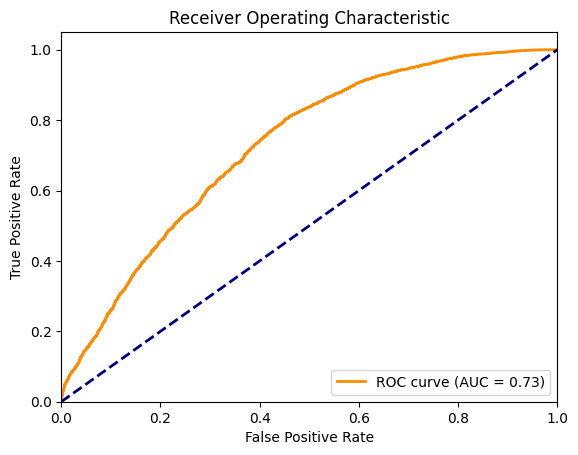

Test AUC: 0.73


In [ ]:
from sklearn.metrics import roc_curve, auc

# Plot the ROC curve and calculate AUC
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

roc_auc = plot_roc_curve(true_labels, similarity_scores)
print("Test AUC: {:.2f}".format(roc_auc))

In [ ]:
# Save the embedding model
embedding.save('embedding_classification.h5')  # or 'embedding_model' for SavedModel format

In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination paths
source = '/content/embedding_classification.h5'
destination = '/content/drive/My Drive/Applied ML/project'

# Move the file
shutil.move(source, destination)

print(f"File moved to {destination}")

Mounted at /content/drive
File moved to /content/drive/My Drive/Applied ML/project
